In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

In [ ]:
base_image_dir = 'F:/newagain'
selected_csv_path = 'F:/new_again.csv'

retina_df = pd.read_csv(selected_csv_path)
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)

print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

1426 images found of 1426 total


In [ ]:
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['level_cat'] = retina_df['level'].astype(str)

retina_df.dropna(inplace=True)
retina_df = retina_df[retina_df['exists']]

retina_df.sample(3)

rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

try:
    train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                            test_size=0.29, 
                                            random_state=5,
                                            stratify=rr_df['level'])
except ValueError:
    print("The dataset is too small to stratify the classes.")
    train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                            test_size=0.29, 
                                            random_state=2018)


In [ ]:
train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

# Image Data Generator
IMG_SIZE = (299, 299)
batch_size = 32

core_idg = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              preprocessing_function=preprocess_input)

valid_idg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = core_idg.flow_from_dataframe(train_df, 
                                         x_col='path',
                                         y_col='level_cat',
                                         target_size=IMG_SIZE,
                                         batch_size=batch_size,
                                         class_mode='categorical')

valid_gen = valid_idg.flow_from_dataframe(valid_df, 
                                          x_col='path',
                                          y_col='level_cat',
                                          target_size=IMG_SIZE,
                                          batch_size=batch_size,
                                          class_mode='categorical')

train 1186 validation 306
Found 1186 validated image filenames belonging to 5 classes.
Found 306 validated image filenames belonging to 5 classes.


In [ ]:
# Model: InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the initial layers and train only the top layers
for layer in base_model.layers:
    layer.trainable = False

# Compile and train the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen,
                    steps_per_epoch=train_df.shape[0] // batch_size,
                    validation_data=valid_gen,
                    validation_steps=valid_df.shape[0] // batch_size,
                    epochs=30)

# Unfreeze some layers and fine-tune the model
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(train_gen,
                              steps_per_epoch=train_df.shape[0] // batch_size,
                              validation_data=valid_gen,
                              validation_steps=valid_df.shape[0] // batch_size,
                              epochs=60)


Epoch 1/30
37/37 [==============================] - 354s 9s/step - loss: 1.5913 - accuracy: 0.6291 - val_loss: 1.0172 - val_accuracy: 0.6667
Epoch 2/30
37/37 [==============================] - 321s 9s/step - loss: 0.9420 - accuracy: 0.6984 - val_loss: 0.9943 - val_accuracy: 0.6667
Epoch 3/30
37/37 [==============================] - 323s 9s/step - loss: 0.8924 - accuracy: 0.7036 - val_loss: 0.9368 - val_accuracy: 0.6736
Epoch 4/30
37/37 [==============================] - 314s 9s/step - loss: 0.8890 - accuracy: 0.6863 - val_loss: 1.0840 - val_accuracy: 0.6632
Epoch 5/30
37/37 [==============================] - 305s 8s/step - loss: 0.8689 - accuracy: 0.7062 - val_loss: 0.9210 - val_accuracy: 0.6840
Epoch 6/30
37/37 [==============================] - 300s 8s/step - loss: 0.8617 - accuracy: 0.7036 - val_loss: 0.9886 - val_accuracy: 0.6771
Epoch 7/30
37/37 [==============================] - 326s 9s/step - loss: 0.8385 - accuracy: 0.7019 - val_loss: 0.9289 - val_accuracy: 0.6597
Epoch 8/30
37

Epoch 1/60
37/37 [==============================] - 288s 8s/step - loss: 0.9729 - accuracy: 0.6802 - val_loss: 4.9353 - val_accuracy: 0.6736
Epoch 2/60
37/37 [==============================] - 300s 8s/step - loss: 0.8627 - accuracy: 0.7062 - val_loss: 1.7729 - val_accuracy: 0.6944
Epoch 3/60
37/37 [==============================] - 323s 9s/step - loss: 0.8233 - accuracy: 0.7045 - val_loss: 0.9703 - val_accuracy: 0.6389
Epoch 4/60
37/37 [==============================] - 316s 9s/step - loss: 0.7534 - accuracy: 0.7192 - val_loss: 1.9149 - val_accuracy: 0.6875
Epoch 5/60
37/37 [==============================] - 268s 7s/step - loss: 0.7580 - accuracy: 0.7210 - val_loss: 1.8299 - val_accuracy: 0.6736
Epoch 6/60
37/37 [==============================] - 266s 7s/step - loss: 0.7183 - accuracy: 0.7279 - val_loss: 1.1483 - val_accuracy: 0.6736
Epoch 7/60
37/37 [==============================] - 269s 7s/step - loss: 0.6595 - accuracy: 0.7461 - val_loss: 1.5044 - val_accuracy: 0.6736
Epoch 8/60
37

9/9 [==============================] - 39s 4s/step - loss: 1.3294 - accuracy: 0.6806
Validation loss:  1.3294456005096436
Validation accuracy:  0.6805555820465088


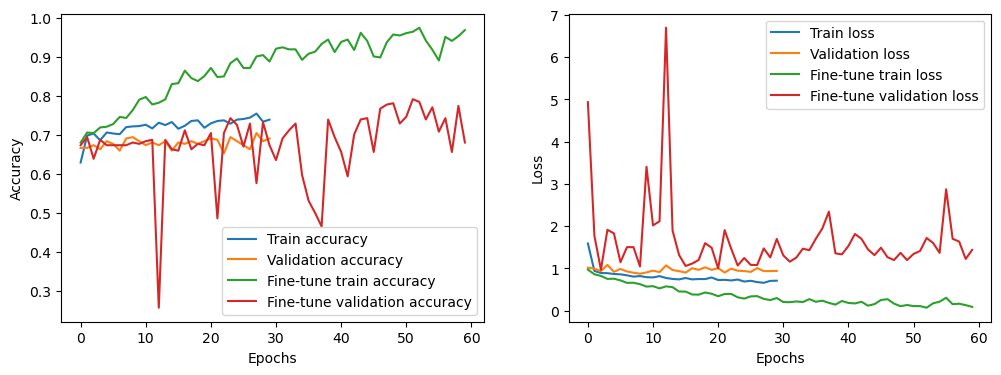

In [ ]:
# Evaluate the fine-tuned model
score = model.evaluate(valid_gen, steps=valid_df.shape[0] // batch_size)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

# Visualize the training process
def plot_training_history(history, history_fine_tune):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.plot(history_fine_tune.history['accuracy'], label='Fine-tune train accuracy')
    plt.plot(history_fine_tune.history['val_accuracy'], label='Fine-tune validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.plot(history_fine_tune.history['loss'], label='Fine-tune train loss')
    plt.plot(history_fine_tune.history['val_loss'], label='Fine-tune validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history, history_fine_tune)

# Save the fine-tuned model
model.save('retina_fine_tuned_model.h5')


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_on_image(image_path, model, img_size=IMG_SIZE):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    
    return predicted_class, predictions[0]


In [ ]:
test_gen = valid_idg.flow_from_dataframe(valid_df, 
                                         x_col='path',
                                         y_col='level_cat',
                                         target_size=IMG_SIZE,
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         shuffle=False)  # We do not shuffle the test dataset

predictions = model.predict(test_gen, steps=valid_df.shape[0] // batch_size)
predicted_classes = np.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes)
print("Predictions:", predictions)



Found 306 validated image filenames belonging to 5 classes.
9/9 [==============================] - 40s 4s/step
Predicted classes: [2 0 1 1 0 0 2 0 2 0 0 0 0 0 0 0 2 0 2 1 0 0 1 0 2 0 2 0 0 0 0 1 0 0 0 3 4
 2 1 0 3 3 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 3 0 1 3 0 0 0 0 0 0 0 0 2
 0 0 2 3 0 0 0 0 1 0 0 2 0 2 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 2 0 0 0 1 0
 2 1 1 0 0 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 4 3 0 0 0 0 0 0 2 1
 0 0 0 0 0 2 0 2 0 0 0 0 1 0 2 0 1 0 0 2 0 0 0 0 4 4 1 1 0 0 2 1 0 1 2 0 0
 0 0 0 0 0 3 3 0 0 1 2 2 0 0 0 0 0 0 1 2 2 2 1 0 0 0 0 1 0 0 0 3 1 1 1 0 0
 0 0 1 0 2 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 1 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 4
 2 2 1 0 0 0 1 0 1 0 0 1 0 0 0 2 0 0 1 0 0 2 0 0 0 0 0 0 0]
Predictions: [[4.1656561e-02 3.5286158e-02 8.7533909e-01 4.4773865e-02 2.9443139e-03]
 [9.5074308e-01 4.6176799e-02 3.0574531e-03 1.5502183e-05 7.1694526e-06]
 [1.1746515e-01 8.8020539e-01 2.2857978e-03 4.1965322e-05 1.7113385e-06]
 ...
 [8.5859025e-01 1.4104539e-01 3.2717423e-04 3.47

In [ ]:
from sklearn.metrics import accuracy_score

# Get the true labels from the test dataset
true_labels = test_gen.classes

# Calculate the accuracy
accuracy = accuracy_score(true_labels[:len(predicted_classes)], predicted_classes)

print("Test accuracy:", accuracy)


Test accuracy: 0.7903333333333334
